# Embeddings

In [16]:
import pickle
with open("data/davis_b3/davis_b3_esm_pretrain.pkl", "rb") as f:
    protein_embeddings_full = pickle.load(f)
    
protein_embeddings = protein_embeddings_full["vec_dict"]
print(len(protein_embeddings))


470


In [17]:
import pandas as pd

# Load protein sequences
pharos_load = pd.read_csv("data/davis_b3/pharos.csv")
davis_load = pd.concat([
    pd.read_csv("data/davis_b3/davis_b3_test_1.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_2.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_3.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_4.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_5.csv")
], ignore_index=True)

# Get sets of protein IDs
davis_protein_ids = set(davis_load["protein_id"])
pharos_protein_ids = set(pharos_load["protein_id"])

print(len(davis_protein_ids))
print(len(pharos_protein_ids))

379
28


In [18]:
# Keep only valid IDs that are actually in the embedding dictionary
davis_protein_embeddings = {pid: protein_embeddings[pid] for pid in davis_protein_ids if pid in protein_embeddings}
pharos_protein_embeddings = {pid: protein_embeddings[pid] for pid in pharos_protein_ids if pid in protein_embeddings}

print(f"{len(davis_protein_embeddings)} DAVIS proteins with embeddings")
print(f"{len(pharos_protein_embeddings)} PHAROS proteins with embeddings")


379 DAVIS proteins with embeddings
28 PHAROS proteins with embeddings


In [19]:
import pandas as pd

# Get sets of protein IDs
davis_drug_ids = set(davis_load["drug_id"].astype(str))
pharos_drug_ids = set(pharos_load["drug_id"])

print(len(davis_drug_ids))
print(len(pharos_drug_ids))

68
209


In [20]:

import pickle
with open("data/davis_b3/davis_b3_mol_pretrain.pkl", "rb") as f:
    drug_embeddings_full = pickle.load(f)
    
# Extract the actual embedding dictionary
drug_embeddings = drug_embeddings_full["vec_dict"]

print(len(drug_embeddings))

# Keep only drug_ids that exist in the embeddings dict
davis_drug_embeddings = {
    did: drug_embeddings[did]
    for did in davis_drug_ids if did in drug_embeddings
}
print(len(davis_drug_embeddings))
pharos_drug_embeddings = {
    did: drug_embeddings[did]
    for did in pharos_drug_ids if did in drug_embeddings
}
print(len(pharos_drug_embeddings))

277
68
209


# ERS Formulation

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from scipy.spatial import Delaunay, ConvexHull
from sklearn.neighbors import NearestNeighbors

# === Load and merge data ===
unblinded_df = pd.read_csv("new/AVG_crossval_predictions.csv")
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")
pharos_df=pd.read_csv("new/AVG_pharos_test_predictions.csv")

unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values
pharos = pharos_df[["True_Label", "Blinded_Prediction"]].values


In [22]:
# === 2. Identify unmatched ===
unblinded_unmatched = pd.merge(
    unblinded_df, merged_df[["Drug_ID", "Protein_ID", "True_Label"]],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    how="left", indicator=True
).query('_merge == "left_only"').drop(columns=["_merge"])

blinded_unmatched = pd.merge(
    blinded_df, merged_df[["Drug_ID", "Protein_ID", "True_Label"]],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    how="left", indicator=True
).query('_merge == "left_only"').drop(columns=["_merge"])

print(f"Unmatched in unblinded: {len(unblinded_unmatched)}")
print(f"Unmatched in blinded: {len(blinded_unmatched)}")

Unmatched in unblinded: 9508
Unmatched in blinded: 3697


In [24]:
# === 3. Iterative matching by rounding True_Label ===
merged_rounded = pd.DataFrame()

for r in [8,7,6,5,4]:
    print(f"\nTrying merge with True_Label rounded to {r} decimals...")
    u = unblinded_unmatched.copy()
    b = blinded_unmatched.copy()

    u["Rounded_Label"] = u["True_Label"].round(r)
    b["Rounded_Label"] = b["True_Label"].round(r)

    merged = pd.merge(
        u[["Drug_ID", "Protein_ID", "Rounded_Label", "True_Label", "Unblinded_Prediction"]],
        b[["Drug_ID", "Protein_ID", "Rounded_Label", "True_Label", "Blinded_Prediction"]],
        on=["Drug_ID", "Protein_ID", "Rounded_Label"],
        suffixes=("_unblinded", "_blinded"),
        how="inner"
    )

    print(f"Matched {len(merged)} more rows at {r} decimals")
    merged_rounded = pd.concat([merged_rounded, merged], ignore_index=True)

    # Update unmatched
    matched_keys = merged[["Drug_ID", "Protein_ID", "Rounded_Label"]].drop_duplicates()
    unblinded_unmatched = pd.merge(u, matched_keys, on=["Drug_ID", "Protein_ID", "Rounded_Label"], how="left", indicator=True)
    unblinded_unmatched = unblinded_unmatched.query('_merge == "left_only"').drop(columns=["_merge"])

    blinded_unmatched = pd.merge(b, matched_keys, on=["Drug_ID", "Protein_ID", "Rounded_Label"], how="left", indicator=True)
    blinded_unmatched = blinded_unmatched.query('_merge == "left_only"').drop(columns=["_merge"])

# === 4. Combine all matched ===
all_merged = pd.concat([
    merged_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction", "Blinded_Prediction"]],
    merged_rounded[["Drug_ID", "Protein_ID", "True_Label_blinded", "Unblinded_Prediction", "Blinded_Prediction"]].rename(columns={"True_Label_blinded": "True_Label"})
], ignore_index=True)

print(f"\nTotal merged: {len(all_merged)}")
print(f"Still unmatched in blinded: {len(blinded_unmatched)}")
print(f"Still unmatched in unblinded: {len(unblinded_unmatched)}")

# Save final datasets if desired
all_merged.to_csv("merged_blinded_unblinded_full.csv", index=False)
blinded_unmatched.to_csv("unmatched_blinded_rows.csv", index=False)


Trying merge with True_Label rounded to 8 decimals...
Matched 0 more rows at 8 decimals

Trying merge with True_Label rounded to 7 decimals...
Matched 0 more rows at 7 decimals

Trying merge with True_Label rounded to 6 decimals...
Matched 0 more rows at 6 decimals

Trying merge with True_Label rounded to 5 decimals...
Matched 0 more rows at 5 decimals

Trying merge with True_Label rounded to 4 decimals...
Matched 0 more rows at 4 decimals

Total merged: 23924
Still unmatched in blinded: 0
Still unmatched in unblinded: 5811


In [25]:
# After iterative merge, use all_merged as gold-standard matched data
unblinded_df = all_merged[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]].copy()
blinded_df   = all_merged[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]].copy()
merged_df = all_merged

# Redefine arrays to use only the merged data
unblinded = all_merged[["True_Label", "Unblinded_Prediction"]].values
blinded   = all_merged[["True_Label", "Blinded_Prediction"]].values

# Leave pharos as-is (it's already separate and untouched)
pharos    = pharos_df[["True_Label", "Blinded_Prediction"]].values

print(len(blinded_df))
print(len(unblinded_df))
print(len(blinded))
print(len(unblinded))

23924
23924
23924
23924


In [26]:
def compute_distance_to_hull(polygon, delaunay, point):
    pt = Point(point)
    nearest = nearest_points(pt, polygon.boundary)[1]
    dist = pt.distance(nearest)
    is_inside = delaunay.find_simplex([point])[0] >= 0
    return dist, is_inside

def compute_continuous_hull_distance(unblinded, blinded_subset):
    from shapely.geometry import Point
    from shapely.ops import nearest_points
    from scipy.spatial import ConvexHull, Delaunay
    import numpy as np
    from shapely.geometry import Polygon

    # === Build hull from unblinded set ===
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # === Step 1: Compute max inside distance from unblinded set only ===
    unblinded_dists = []
    for point in unblinded:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        if is_inside:
            unblinded_dists.append(dist)

    max_inside = max(unblinded_dists) if unblinded_dists else 0.0

    # === Step 2: Compute adjusted distances for blinded points ===
    dists = []
    is_inside_list = []

    for point in blinded_subset:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        dists.append(dist)
        is_inside_list.append(is_inside)

    dists = np.array(dists)
    is_inside = np.array(is_inside_list)

    adjusted_dist = dists.copy()
    adjusted_dist[is_inside] = max_inside - dists[is_inside]   # inside: 0 = deepest
    adjusted_dist[~is_inside] = dists[~is_inside] + max_inside  # outside: continues upward

    return adjusted_dist, is_inside



def estimate_sparse_weight(unblinded, blinded_subset, k=20):
    """
    Estimate sparsity weight for each point in `blinded_subset` based on its
    k-NN density relative to the `unblinded` training data. Uses log-density
    and z-score normalization for better comparability across models.

    Returns:
        sparsity_z: array of sparsity scores (higher = more sparse)
    """
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    # Step 1: Fit k-NN on unblinded
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(unblinded)

    # Step 2: Compute unblinded point densities
    dists_unblinded, _ = nn.kneighbors(unblinded)
    density_unblinded = 1 / (dists_unblinded.mean(axis=1) + 1e-8)
    log_density_unblinded = np.log(density_unblinded + 1e-8)

    # Step 3: Compute blinded point densities
    dists_blinded, _ = nn.kneighbors(blinded_subset)
    density_blinded = 1 / (dists_blinded.mean(axis=1) + 1e-8)
    log_density_blinded = np.log(density_blinded + 1e-8)

    # Step 4: Compute z-score sparsity on log scale (higher = more sparse)
    mu = np.mean(log_density_unblinded)
    sigma = np.std(log_density_unblinded) + 1e-8
    sparsity_z = (mu - log_density_blinded) / sigma

    return sparsity_z


# === Final hybrid ERS computation ===
def compute_ERS_for_points(unblinded, blinded_subset, gamma=5.0, k=5, merged=None, use_cspd=True):
    cspd = None
    continuous_hull_distance, is_inside = compute_continuous_hull_distance(unblinded, blinded_subset)
    # Possibly override with CSPD if requested
    if use_cspd and merged is not None:
        cspd = np.abs((merged["Unblinded_Prediction"] - merged["Blinded_Prediction"]))
        dists_for_ERS = cspd
    else:
        dists_for_ERS = continuous_hull_distance

    # Sparsity
    sparsity_weights = np.maximum(estimate_sparse_weight(unblinded, blinded_subset, k=k), 1e-3) #THINK ABOUT THIS PART MORE

    # ERS
    print(len(dists_for_ERS))
    print(len(sparsity_weights))
    ERS_vals = dists_for_ERS * sparsity_weights
    print(len(ERS_vals))

    return ERS_vals, continuous_hull_distance, sparsity_weights, cspd, is_inside

def plot_ERS_overlay(unblinded, blinded_subset, ERS_vals,type):
    hull = ConvexHull(unblinded)
    plt.figure(figsize=(8, 6))

    # Plot convex hull boundary
    for simplex in hull.simplices:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'k--', lw=1)

    # Plot unblinded points
    plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Simulated Warm Start')

    # === Set symmetric vmin/vmax to center color at 0 ===
    max_abs = np.max(np.abs(ERS_vals))  # maximum absolute ERS value

    sc = plt.scatter(
        blinded_subset[:, 0], blinded_subset[:, 1],
        c=ERS_vals, cmap='coolwarm', edgecolor='black', s=80, label='Simulated Cold Start',
        # vmin=-max_abs, vmax=max_abs  # center at 0
    )

    plt.colorbar(sc, label='ERS Score')
    plt.xlabel("True Label")
    plt.ylabel("Prediction")
    plt.legend(
        loc='upper center',          # places it near the top of the plot
        bbox_to_anchor=(0.5, 1),  # (x, y) relative to axes, increase y to move up
        ncol=1,                      # keeps entries side by side 
        frameon=True
    )
    plt.title(f"DAVIS Simulated Cold Start ERS using {type} \n Overlaid on Convex Hull")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import numpy as np

def print_ers_statistics(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    inside_vals = ERS_vals[is_inside]
    outside_vals = ERS_vals[~is_inside]

    print("=== ERS Statistics ===")
    print(f"Total Points: {len(ERS_vals)}")
    print(f"Inside Hull: {len(inside_vals)}")
    print(f"Outside Hull: {len(outside_vals)}")

    print("\n--- Overall ---")
    print(f"Mean ERS: {ERS_vals.mean():.3f}")
    print(f"Median ERS: {np.median(ERS_vals):.3f}")
    print(f"Max ERS: {ERS_vals.max():.3f}")
    print(f"Std Dev: {ERS_vals.std():.3f}")

    print("\n--- Inside Hull ---")
    print(f"Mean ERS: {inside_vals.mean():.3f}")
    print(f"Median ERS: {np.median(inside_vals):.3f}")
    print(f"Max ERS: {inside_vals.max():.3f}")
    print(f"Std Dev: {inside_vals.std():.3f}")

    print("\n--- Outside Hull ---")
    print(f"Mean ERS: {outside_vals.mean():.3f}")
    print(f"Median ERS: {np.median(outside_vals):.3f}")
    print(f"Max ERS: {outside_vals.max():.3f}")
    print(f"Std Dev: {outside_vals.std():.3f}")



23924
23924
23924


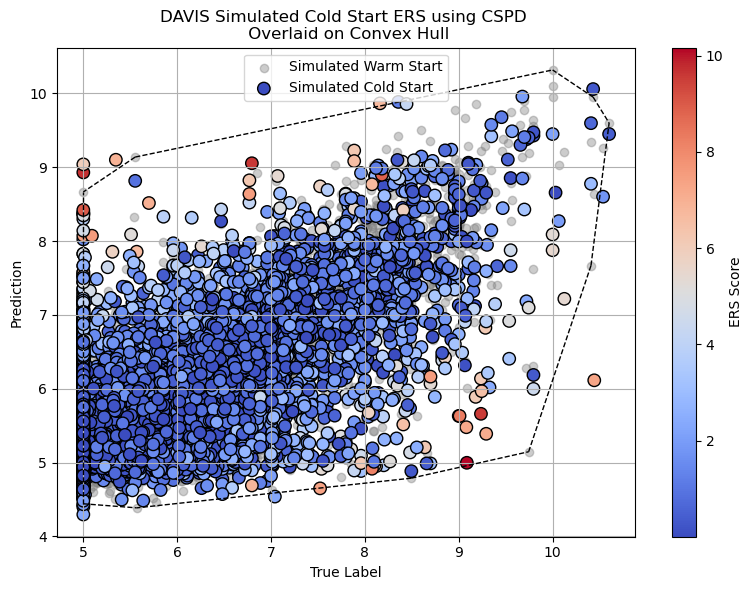

=== ERS Statistics ===
Total Points: 23924
Inside Hull: 23909
Outside Hull: 15

--- Overall ---
Mean ERS: 0.262
Median ERS: 0.000
Max ERS: 10.167
Std Dev: 0.681

--- Inside Hull ---
Mean ERS: 0.260
Median ERS: 0.000
Max ERS: 10.167
Std Dev: 0.671

--- Outside Hull ---
Mean ERS: 3.832
Median ERS: 2.283
Max ERS: 9.728
Std Dev: 3.006
23924
23924
23924


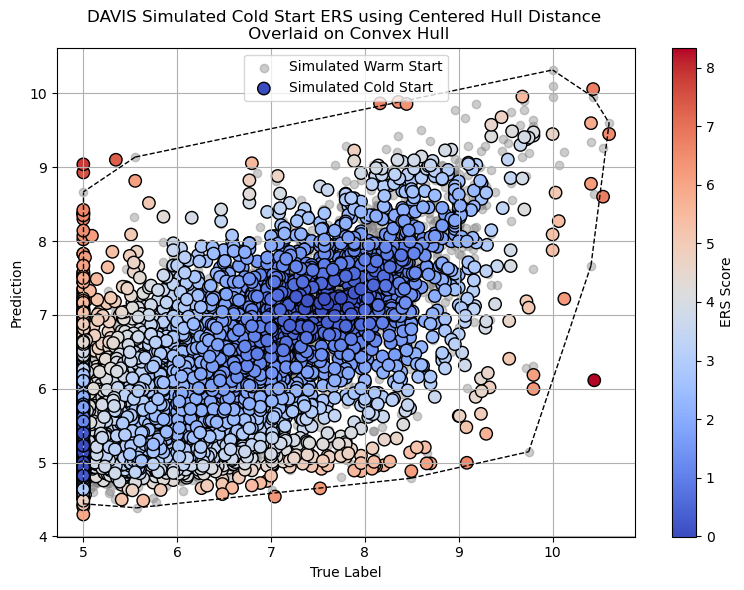

=== ERS Statistics ===
Total Points: 23924
Inside Hull: 23909
Outside Hull: 15

--- Overall ---
Mean ERS: 0.733
Median ERS: 0.002
Max ERS: 8.340
Std Dev: 1.246

--- Inside Hull ---
Mean ERS: 0.729
Median ERS: 0.002
Max ERS: 6.675
Std Dev: 1.238

--- Outside Hull ---
Mean ERS: 6.557
Median ERS: 6.566
Max ERS: 8.340
Std Dev: 0.923
310
310
310


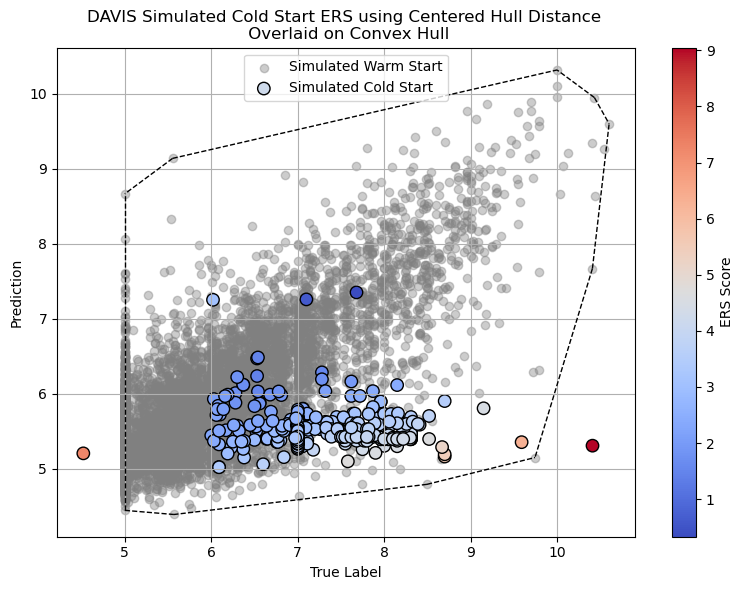

=== ERS Statistics ===
Total Points: 310
Inside Hull: 308
Outside Hull: 2

--- Overall ---
Mean ERS: 3.236
Median ERS: 3.190
Max ERS: 9.047
Std Dev: 0.867

--- Inside Hull ---
Mean ERS: 3.204
Median ERS: 3.188
Max ERS: 6.295
Std Dev: 0.770

--- Outside Hull ---
Mean ERS: 8.155
Median ERS: 8.155
Max ERS: 9.047
Std Dev: 0.892


In [27]:
# === Run ===
ERS_vals_cspd, dists_blinded_cspd, sparsity_weights_cspd, cspds_cspd, is_inside_bl = compute_ERS_for_points(unblinded, blinded, gamma=5.0, k=20, merged =merged_df, use_cspd=True)
plot_ERS_overlay(unblinded, blinded, ERS_vals_cspd,"CSPD")
print_ers_statistics(ERS_vals_cspd, is_inside_bl)

ERS_vals, dists_blinded, sparsity_weights, cspds, is_inside_bl = compute_ERS_for_points(unblinded, blinded, gamma=5.0, k=20, merged =merged_df, use_cspd=False)
plot_ERS_overlay(unblinded, blinded, ERS_vals,"Centered Hull Distance")
print_ers_statistics(ERS_vals, is_inside_bl)


# === Run ===
ERS_vals_p, dists_blinded_p, sparsity_weights_p, _, is_inside_p = compute_ERS_for_points(unblinded, pharos, gamma=5.0, k=20)
plot_ERS_overlay(unblinded, pharos, ERS_vals_p, "Centered Hull Distance")
print_ers_statistics(ERS_vals_p, is_inside_p)


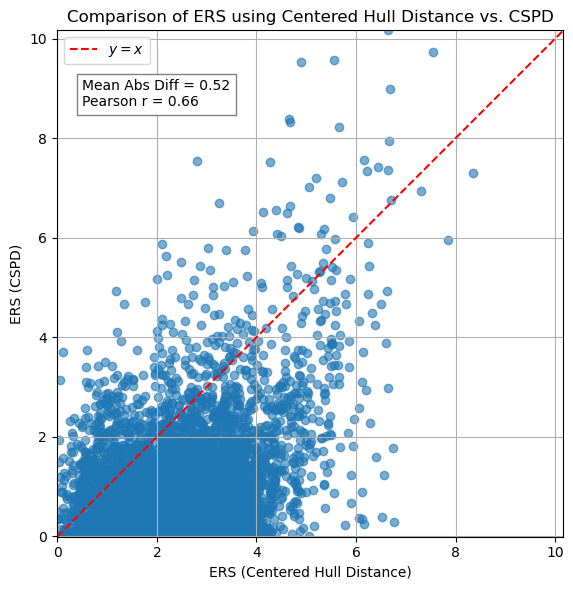

Mean absolute difference: 0.5178678335389534
Pearson correlation: 0.6584225092662936


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute the difference
ERS_vals_cspd = np.array(ERS_vals_cspd)
ERS_vals_hull = np.array(ERS_vals)

# Ensure same shape
assert ERS_vals_cspd.shape == ERS_vals_hull.shape

# Define common axis limits
min_val = min(ERS_vals_hull.min(), ERS_vals_cspd.min())
max_val = max(ERS_vals_hull.max(), ERS_vals_cspd.max())
# Compute stats
diff = np.abs(ERS_vals_cspd - ERS_vals_hull)
mad = diff.mean()
corr = np.corrcoef(ERS_vals_hull, ERS_vals_cspd)[0, 1]
# Scatter plot
plt.figure(figsize=(6, 6))
plt.axis("square")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.scatter(ERS_vals_hull, ERS_vals_cspd, alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$')

# Annotate statistics
text_x = min_val + 0.05 * (max_val - min_val)
text_y = max_val - 0.15 * (max_val - min_val)
plt.text(text_x, text_y, f"Mean Abs Diff = {mad:.2f}\nPearson r = {corr:.2f}", fontsize=10, bbox=dict(facecolor='white', edgecolor='gray'))


plt.xlabel("ERS (Centered Hull Distance)")
plt.ylabel("ERS (CSPD)")
plt.title("Comparison of ERS using Centered Hull Distance vs. CSPD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print mean absolute difference and correlation
diff = np.abs(ERS_vals_cspd - ERS_vals_hull)
print("Mean absolute difference:", diff.mean())
print("Pearson correlation:", np.corrcoef(ERS_vals_hull, ERS_vals_cspd)[0, 1])



Inside Hull:
  Mean absolute difference: 0.516202791142377
  Pearson correlation: 0.6560897509100854


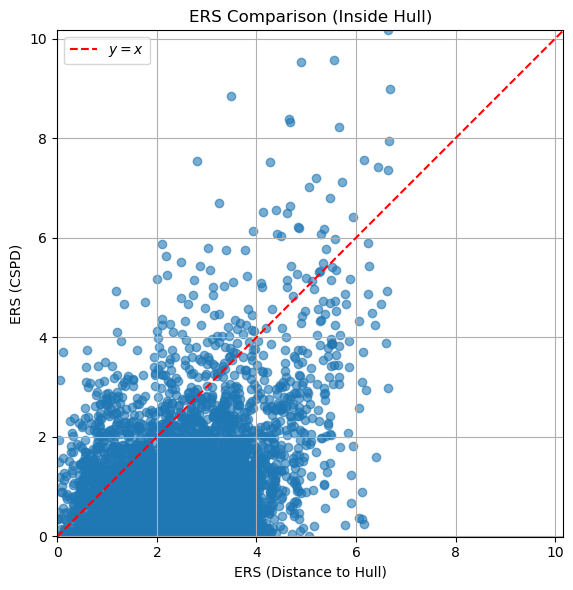


Outside Hull:
  Mean absolute difference: 3.171834410855377
  Pearson correlation: 0.6129394541620851


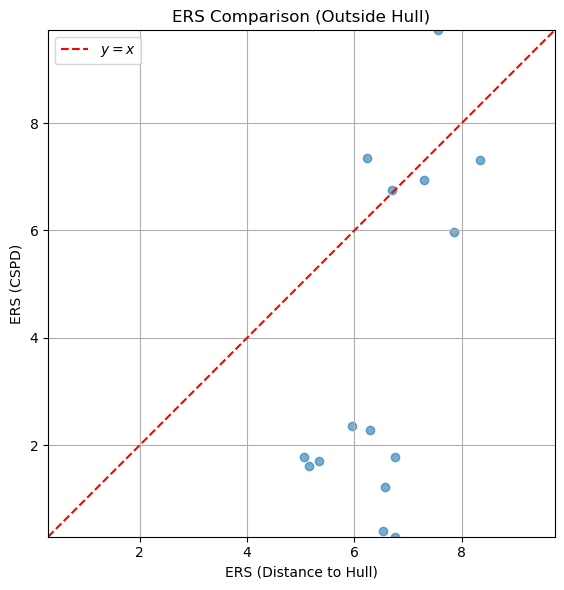

In [29]:
# Convert to arrays if needed
ERS_vals_cspd = np.array(ERS_vals_cspd)
ERS_vals_hull = np.array(ERS_vals)
is_inside_bl = np.array(is_inside_bl)  # True = inside hull

# Masked splits
inside_mask = is_inside_bl
outside_mask = ~is_inside_bl

# Compute metrics
for label, mask in [("Inside Hull", inside_mask), ("Outside Hull", outside_mask)]:
    hull_vals = ERS_vals_hull[mask]
    cspd_vals = ERS_vals_cspd[mask]
    diff = np.abs(hull_vals - cspd_vals)
    corr = np.corrcoef(hull_vals, cspd_vals)[0, 1]
    print(f"\n{label}:")
    print("  Mean absolute difference:", diff.mean())
    print("  Pearson correlation:", corr)

    # Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(hull_vals, cspd_vals, alpha=0.6)
    
    # Get common axis range
    min_val = min(hull_vals.min(), cspd_vals.min())
    max_val = max(hull_vals.max(), cspd_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$')
    
    # Set same axis scale
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.gca().set_aspect('equal', adjustable='box')  # Force square aspect ratio
    
    plt.xlabel("ERS (Distance to Hull)")
    plt.ylabel("ERS (CSPD)")
    plt.title(f"ERS Comparison ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


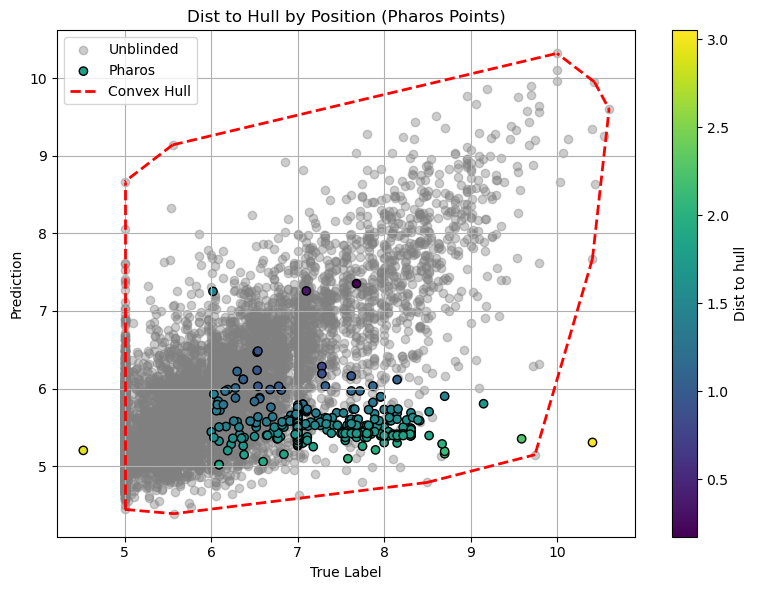

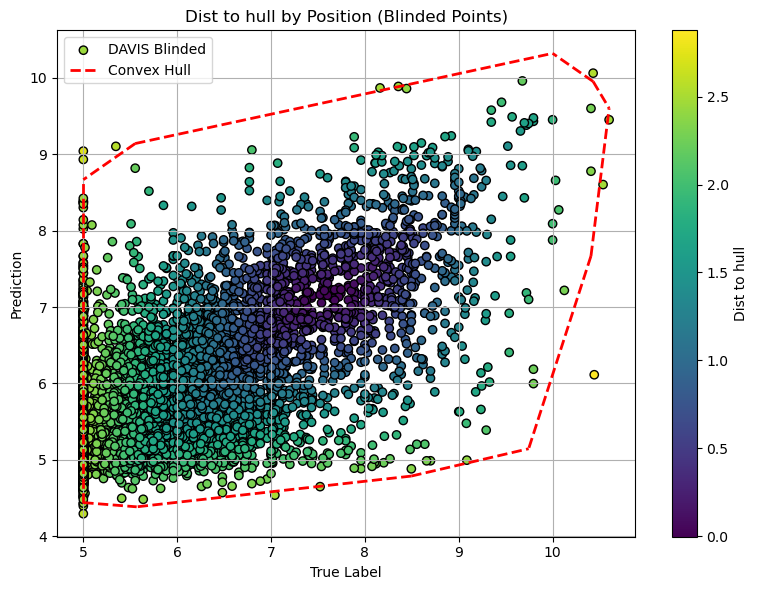

In [32]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Compute convex hull on unblinded points
hull = ConvexHull(unblinded)

plt.figure(figsize=(8, 6))

# Unblinded points in gray
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')

# Pharos points colored by distance to hull
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=dists_blinded_p, cmap='viridis', edgecolor='black', label='Pharos')
plt.colorbar(sc, label="Dist to hull")

# Plot convex hull edges (label only once)
for i, simplex in enumerate(hull.simplices):
    if i == 0:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2, label='Convex Hull')
    else:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2)

plt.title("Dist to Hull by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
# Pharos points colored by distance to hull
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=dists_blinded, cmap='viridis', edgecolor='black', label='DAVIS Blinded')
plt.colorbar(sc, label="Dist to hull")

# Plot convex hull edges (label only once)
for i, simplex in enumerate(hull.simplices):
    if i == 0:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2, label='Convex Hull')
    else:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2)

plt.title("Dist to hull by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




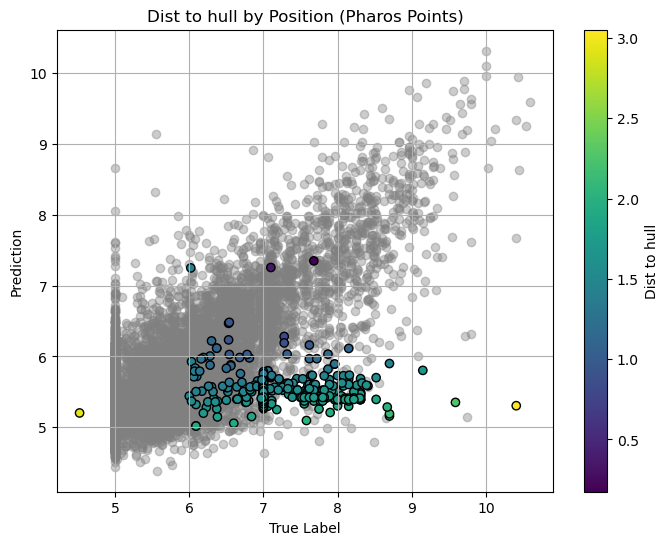

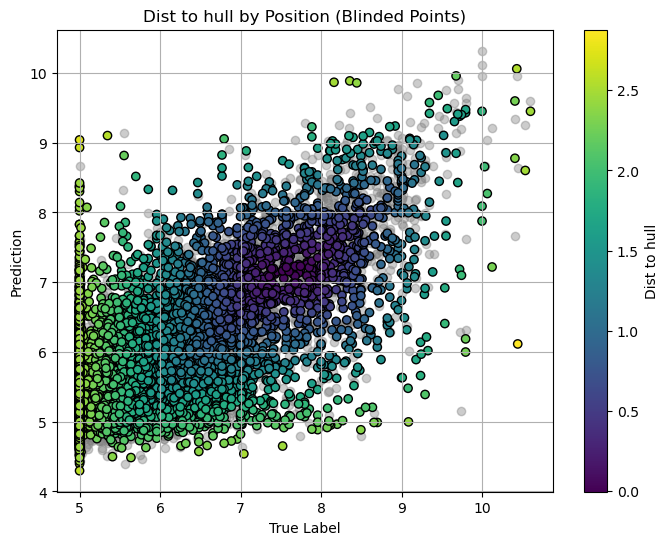

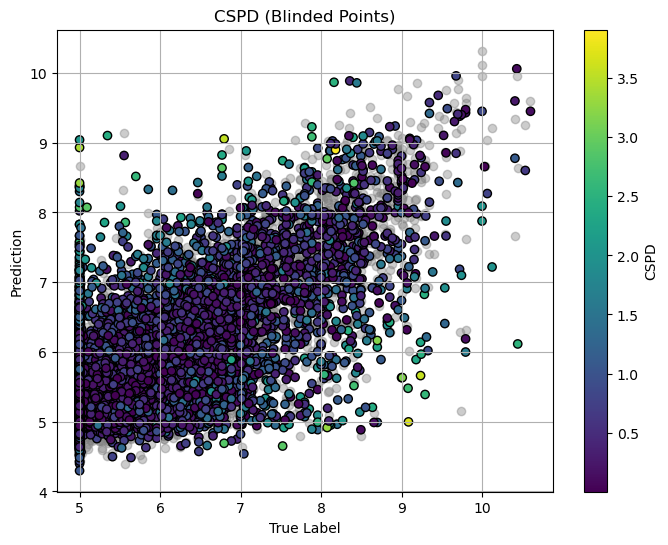

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=dists_blinded_p, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Dist to hull")
plt.title("Dist to hull by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=dists_blinded, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Dist to hull")
plt.title("Dist to hull by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=cspds_cspd, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="CSPD")
plt.title("CSPD (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

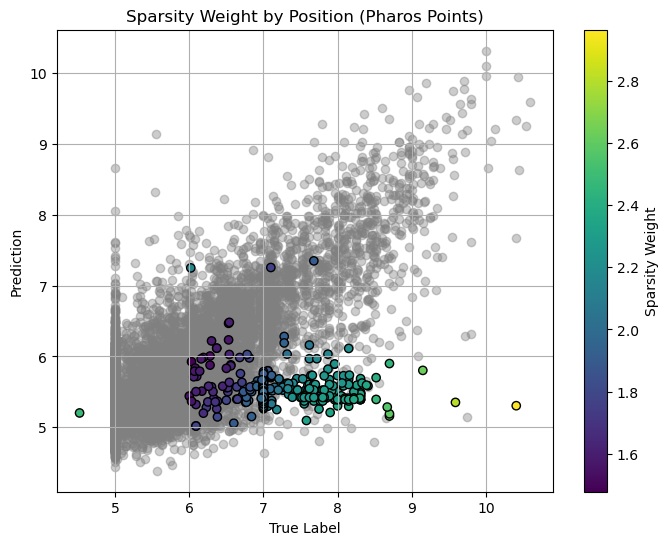

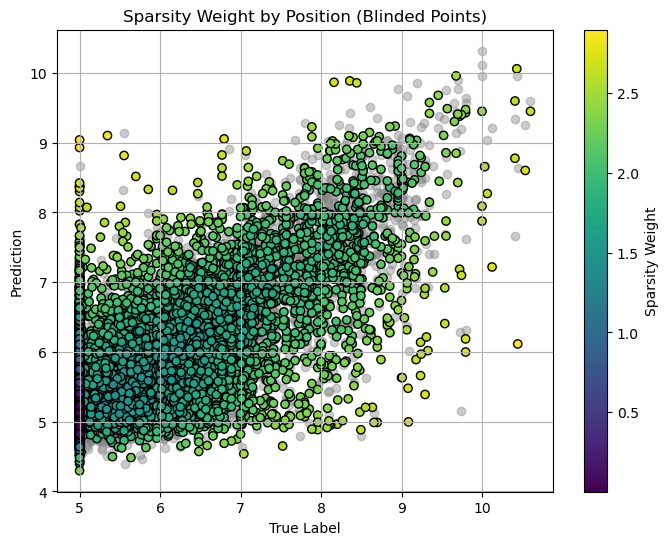

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=sparsity_weights_p, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Sparsity Weight")
plt.title("Sparsity Weight by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=sparsity_weights, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Sparsity Weight")
plt.title("Sparsity Weight by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

# SHOW THAT CSPD CORRELATES WITH signed DIST FROM CONVEX HULL 
and thus using dist from hull as proxy for cspd in pharos case is logical

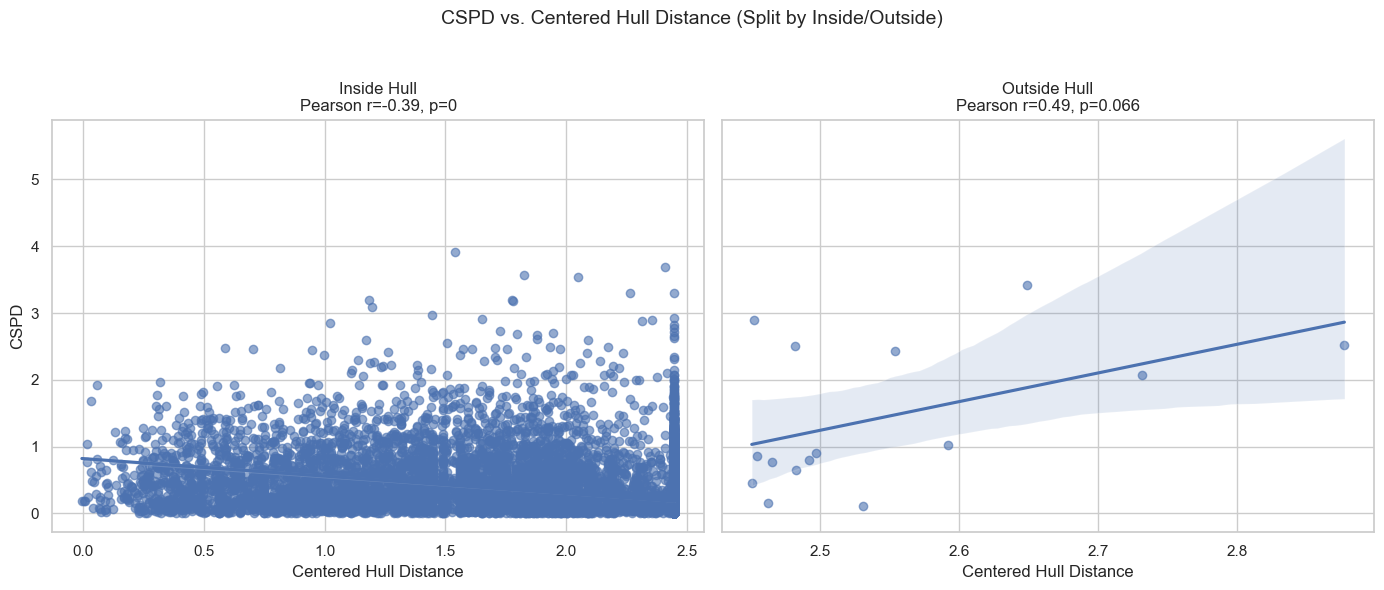

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Convert to arrays

dists_blinded_cspd = np.array(dists_blinded_cspd)
cspds_cspd = np.array(cspds_cspd)

inside_mask = is_inside_bl
outside_mask = ~is_inside_bl


sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# === Inside points ===
sns.regplot(
    x=dists_blinded_cspd[inside_mask],
    y=cspds_cspd[inside_mask],
    scatter_kws={'alpha': 0.6},
    ax=axes[0]
)
r_in, p_in = pearsonr(dists_blinded_cspd[inside_mask], cspds_cspd[inside_mask])
axes[0].set_title(f'Inside Hull\nPearson r={r_in:.2f}, p={p_in:.2g}')
axes[0].set_xlabel('Centered Hull Distance')
axes[0].set_ylabel('CSPD')

# === Outside points ===
sns.regplot(
    x=dists_blinded_cspd[outside_mask],
    y=cspds_cspd[outside_mask],
    scatter_kws={'alpha': 0.6},
    ax=axes[1]
)
r_out, p_out = pearsonr(dists_blinded_cspd[outside_mask], cspds_cspd[outside_mask])
axes[1].set_title(f'Outside Hull\nPearson r={r_out:.2f}, p={p_out:.2g}')
axes[1].set_xlabel('Centered Hull Distance')
axes[1].set_ylabel('')  # shared y-axis
 
plt.suptitle('CSPD vs. Centered Hull Distance (Split by Inside/Outside)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Affinity_Bin: 23924
ERS: 23924
CSPD: 23924
Abs_Diff: 23924


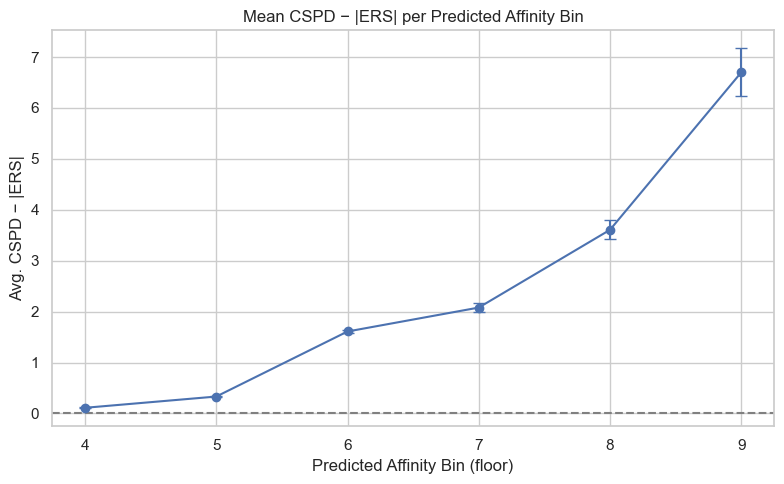

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Sanity check
# Compute CSPD
cspds = np.abs(ERS_vals) * sparsity_weights

# Bin by integer-valued predicted affinity
aff_bin = np.floor(blinded_df["Blinded_Prediction"]).astype(int)

# Compute difference between CSPD and |ERS|
diffs = cspds - np.abs(ERS_vals)

print("Affinity_Bin:", len(aff_bin))
print("ERS:", len(ERS_vals))
print("CSPD:", len(cspds))
print("Abs_Diff:", len(diffs))


# Create DataFrame
df = pd.DataFrame({
    "Affinity_Bin": aff_bin,
    "ERS": ERS_vals,
    "CSPD": cspds,
    "Abs_Diff": diffs
})

# Group and plot average difference per bin
grouped = df.groupby("Affinity_Bin")["Abs_Diff"].agg(["mean", "count", "std"])
grouped = grouped[grouped["count"] >= 5]  # drop small bins for stability

plt.figure(figsize=(8, 5))
plt.errorbar(
    grouped.index,
    grouped["mean"],
    yerr=grouped["std"] / np.sqrt(grouped["count"]),  # SEM
    fmt='o-', capsize=4
)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Affinity Bin (floor)")
plt.ylabel("Avg. CSPD − |ERS|")
plt.title("Mean CSPD − |ERS| per Predicted Affinity Bin")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_34767/210324814.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = bin_df.groupby("bin").mean()


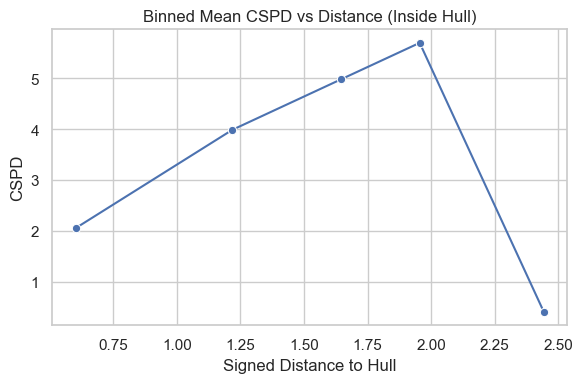

In [37]:
import pandas as pd
bin_df = pd.DataFrame({
    "distance": dists_blinded[inside_mask],
    "cspd": cspds[inside_mask]
})
bin_df["bin"] = pd.qcut(bin_df["distance"], q=20, duplicates="drop")
bin_means = bin_df.groupby("bin").mean()

plt.figure(figsize=(6,4))
sns.lineplot(data=bin_means, x="distance", y="cspd", marker="o")
plt.title("Binned Mean CSPD vs Distance (Inside Hull)")
plt.xlabel("Signed Distance to Hull")
plt.ylabel("CSPD")
plt.grid(True)
plt.tight_layout()
plt.show()


# CSVS
turn ERS and chr into csvs

(#inside pts/#total pts)(avg ERS inside) + (#outside pts/#total pts)(avg ERS outside) but would weight the inside points heavily

so maybe CSVS_model = CHR * mean_ERS_outside
CHR is the fraction of outside points

In [38]:
def compute_model_level_csvs(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    # Boolean masks
    inside_mask = is_inside
    outside_mask = ~is_inside

    # Count totals
    num_total = len(ERS_vals)
    num_inside = inside_mask.sum()
    num_outside = outside_mask.sum()

    # Compute CHR
    CHR = num_outside / num_total if num_total > 0 else 0.0

    # Means (safe fallback to NaN if no points)
    mean_ERS_inside = ERS_vals[inside_mask].mean() if num_inside > 0 else np.nan
    mean_ERS_outside = ERS_vals[outside_mask].mean() if num_outside > 0 else np.nan

    # === Option 1: Weighted Average (original proposal) ===
    CSVS_weighted = (
        (num_inside / num_total) * mean_ERS_inside +
        (num_outside / num_total) * mean_ERS_outside
        if num_total > 0 else np.nan
    )

    # === Option 2: CHR-weighted outside ERS (recommended) ===
    CSVS_chr_scaled = CHR * mean_ERS_outside if mean_ERS_outside is not np.nan else np.nan

    return {
        "CHR": CHR,
        "Mean_ERS_inside": mean_ERS_inside,
        "Mean_ERS_outside": mean_ERS_outside,
        "CSVS_weighted": CSVS_weighted,
        "CSVS_chr_scaled": CSVS_chr_scaled
    }

In [39]:
print("CSVS DAVIS UNBLINDED")
results = compute_model_level_csvs(ERS_vals, is_inside_bl)
print("CHR:", results["CHR"])
print("Mean ERS (inside):", results["Mean_ERS_inside"])
print("Mean ERS (outside):", results["Mean_ERS_outside"])
print("CSVS (weighted):", results["CSVS_weighted"])
print("CSVS (CHR × mean outside ERS):", results["CSVS_chr_scaled"])

print("CSVS PHAROS")
results_p = compute_model_level_csvs(ERS_vals_p, is_inside_p)
print("CHR:", results_p["CHR"])
print("Mean ERS (inside):", results_p["Mean_ERS_inside"])
print("Mean ERS (outside):", results_p["Mean_ERS_outside"])
print("CSVS (weighted):", results_p["CSVS_weighted"])
print("CSVS (CHR × mean outside ERS):", results_p["CSVS_chr_scaled"])

CSVS DAVIS UNBLINDED
CHR: 0.0006269854539374686
Mean ERS (inside): 0.7293718512060129
Mean ERS (outside): 6.5573740318597755
CSVS (weighted): 0.7330259237987987
CSVS (CHR × mean outside ERS): 0.00411137813400337
CSVS PHAROS
CHR: 0.0064516129032258064
Mean ERS (inside): 3.2038037956518584
Mean ERS (outside): 8.154818029946572
CSVS (weighted): 3.2357458229698883
CSVS (CHR × mean outside ERS): 0.052611729225461756
